In [32]:
import tensorflow as tf 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

print("Tensorflow version:", tf.__version__)
tf.random.set_seed(22)

Tensorflow version: 2.12.0


In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', "Origin"]

# loading the dataset
dataset = pd.read_csv(url, names = column_names, na_values="?", comment = '\t', sep = ' ', skipinitialspace=True)
dataset.dropna(inplace=True)

# We can convert this into a tensor
dataset_tf = tf.convert_to_tensor(dataset, dtype = tf.float32)

In [9]:
# Splitting into training and testing sets
dataset_shuffled = tf.random.shuffle(dataset_tf, seed = 22)
train_data, test_data = dataset_shuffled[100:], dataset_shuffled[:100]
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

In [13]:
def one_hot_origin(x): 

    origin = tf.cast(x[:, -1], tf.int32)

    origin_oh = tf.one_hot(origin - 1, 3)
    x_ohe = tf.concat([x[:, :-1], origin_oh], axis = 1)
    return x_ohe

In [21]:
x_train_ohe, x_test_ohe = one_hot_origin(x_train), one_hot_origin(x_test)

In [22]:
class Normalize(tf.Module): 

    def __init__(self, x): 
        self.mean = tf.math.reduce_mean(x, axis = 0)
        self.std = tf.math.reduce_std(x, axis = 0)

    def norm(self, x): 
        return (x - self.mean)/self.std

    def unnorm(self, x): 
        return (x * self.std) + self.mean
    
    

In [23]:
norm_x = Normalize(x_train_ohe)
norm_y = Normalize(y_train)

x_train_norm, y_train_norm = norm_x.norm(x_train_ohe), norm_y.norm(y_train)
x_test_norm, y_test_norm = norm_x.norm(x_test_ohe), norm_y.norm(y_test)

We are going to make a linear regression class using the native tensorflow objects

In [26]:
class LinearRegression(tf.Module): 

    def __init__(self):
        self.built = False

    @tf.function 
    def __call__(self, x): 

        if not self.built: 
            rand_w = tf.random.uniform(shape = [x.shape[-1], 1])
            rand_b = tf.random.uniform(shape = [])
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True

        # We are adding these tensors together
        y = tf.add(tf.matmul(x, self.w), self.b)
        return tf.squeeze(y, axis = 1)

In [ ]:
lin_reg = LinearRegression() 
prediction = lin_reg(x_train_norm[:1])
prediction_unnorm = norm_y.unnorm(prediction)

In [29]:
def mse_loss(y_pred, y): 
    return tf.reduce_mean(tf.square(y_pred - y))

In [30]:
# Going to batch our dataset into batches of 64 here
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

# Set training parameters 
epochs = 100 
learning_rate = 0.01 
train_losses = []
test_losses = [] 

for epoch in range(epochs): 
    batch_losses_train = []
    batch_losses_test = [] 

    for x_batch, y_batch in train_dataset: 
        with tf.GradientTape() as tape: 
            y_pred_batch = lin_reg(x_batch)
            batch_loss = mse_loss(y_pred_batch, y_batch)

        grads = tape.gradient(batch_loss, lin_reg.variables)

        # Doing gradient descent here
        for g, v in zip(grads, lin_reg.variables): 
            v.assign_sub(learning_rate * g)

        batch_losses_train.append(batch_loss)

    # Iterate through the testing data
    for x_batch, y_batch in test_dataset:
        y_pred_batch = lin_reg(x_batch)
        batch_loss = mse_loss(y_pred_batch, y_batch)
        # Keep track of batch-level testing performance 
        batch_losses_test.append(batch_loss)

     # Keep track of epoch-level model performance
    train_loss = tf.reduce_mean(batch_losses_train)
    test_loss = tf.reduce_mean(batch_losses_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if epoch % 10 == 0: 
        print(f'Mean squared error for step {epoch}: {train_loss.numpy():0.3f}')

# Output final losses
print(f"\nFinal train loss: {train_loss:0.3f}")
print(f"Final test loss: {test_loss:0.3f}")       

    

2023-06-30 16:12:20.937478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [292,9]
	 [[{{node Placeholder/_0}}]]
2023-06-30 16:12:21.067098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]


Mean squared error for step 0: 2.939
Mean squared error for step 10: 0.490
Mean squared error for step 20: 0.297
Mean squared error for step 30: 0.236
Mean squared error for step 40: 0.208
Mean squared error for step 50: 0.199
Mean squared error for step 60: 0.191
Mean squared error for step 70: 0.187
Mean squared error for step 80: 0.179
Mean squared error for step 90: 0.176

Final train loss: 0.180
Final test loss: 0.221


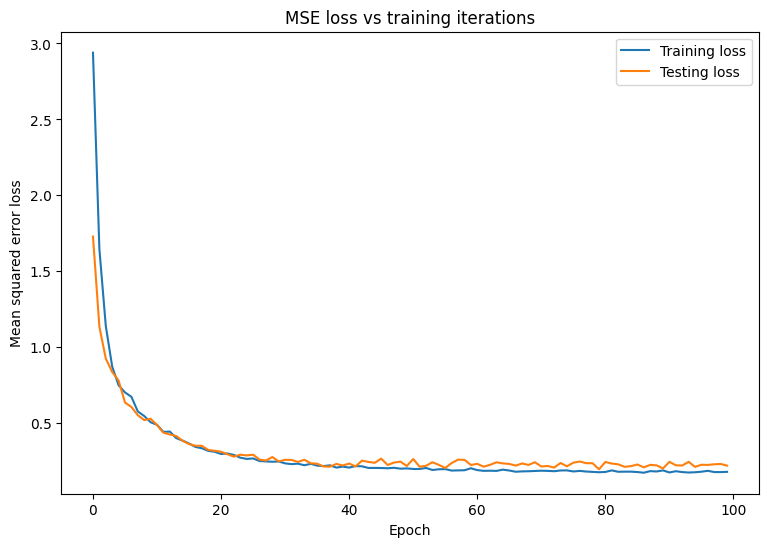

In [33]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()
plt.title("MSE loss vs training iterations");

In [35]:
class ExportModule(tf.Module):
  def __init__(self, model, extract_features, norm_x, norm_y):
    # Initialize pre and postprocessing functions
    self.model = model
    self.extract_features = extract_features
    self.norm_x = norm_x
    self.norm_y = norm_y

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.extract_features(x)
    x = self.norm_x.norm(x)
    y = self.model(x)
    y = self.norm_y.unnorm(y)
    return y
  
lin_reg_export = ExportModule(model=lin_reg,
                              extract_features=one_hot_origin,
                              norm_x=norm_x,
                              norm_y=norm_y)

In [36]:
import tempfile
import os

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'lin_reg_export')
tf.saved_model.save(lin_reg_export, save_path)

INFO:tensorflow:Assets written to: /tmp/tmpuw8dcnk3/lin_reg_export/assets


In [37]:
lin_reg_loaded = tf.saved_model.load(save_path)
test_preds = lin_reg_loaded(x_test)
test_preds[:10].numpy()

array([26.575157, 22.20506 , 22.075827, 23.543005, 14.781026, 27.390034,
       29.829918, 20.630136, 19.815458, 35.224762], dtype=float32)

#### Conclusion

We have gone through implementing simple linear regression using the tensorflow lower level API of tensors, gradient tape, etc. We are going to keep going and see how to do logistic regression as well. 

Some follow up questions: 
* How does GradientTape work at a lower level? How does it know how to compute the gradient? 
* Can we use other loss functions here? 

In [38]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape: 
    y = x ** 2

In [40]:
dy_dx = tape.gradient(y, x)

In [43]:
dy_dx.numpy()

6.0

It's interesting. How we can think about the Gradient Tape is that it's understanding the loss function as a set of steps and is utilizing the chain rule to compute the total gradient. There is a description of what's going on [here](https://www.tensorflow.org/guide/autodiff#:~:text=Gradient%20tapes,-TensorFlow%20provides%20the&text=TensorFlow%20%22records%22%20relevant%20operations%20executed,computation%20using%20reverse%20mode%20differentiation.)